# <b> Yukie Kuang Capstone: Colon Tissue Image Classification 

## Table of Contents
[Sprint 1](#capstone-sprint-1)
- [Dataset](#dataset)<br>
- [Setup Enviornment](#setup-enviornment)<br>
- [Preliminary EDA](#exploratory-data-analysis)
<br>

[Sprint 2](#sprint-2)
- [Overview]()


## Sprint 1:


## Overview 

Utilizing the MHIST dataset, as referenced in a recent publication and another available on GitHub taken from the hospital in Chaoyang, Beijing, this project's primary objective is to develop a machine learning model that can accurately identify malignancies in various colon tissue biopsies. This effort is particularly significant for researchers specializing in gastrointestinal anatomy, as it provides valuable insights with the potential to drive further research and contribute to the development of new treatments for colon-related diseases.

The initial phase of this project involves conducting basic exploratory analysis and visualization of the two datasets. Our approach, centered around the use of advanced methodologies like convolutional neural networks, aims to achieve two key goals: firstly, to significantly improve the accuracy of classifying diseased colon tissue, and secondly, to enhance our comprehension of the unique challenges and possibilities inherent in applying AI to medical image analysis. This dual focus aligns with the broader goal of harnessing AI's power to revolutionize diagnostic processes in the field of pathology. 

## Dataset

<br>The datasets comes with labeled .csv files that lables the images.

<br>[MHIST](https://bmirds.github.io/MHIST/)
<br>_Contains:_
- Test 977 images
- Train 2,175 
<br>* dataset is not split 
- 

<br>[Chaoyang](https://github.com/bupt-ai-cz/HSA-NRL/?tab=readme-ov-file)
<br>_Contains:_
- Test 2,139 images 
- Train 4,021 images
<br>* were already pre-split into seperate folders upon download
- 

## Setup Enviornment


In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tifffile
import tensorflow as tf
import os
from PIL import Image
import cv2
import json


# Exploratory Data Analysis

First we will extract some information from the csv files in the Chaoyang and MHIST dataset.

In [58]:
mhist_csv = pd.read_csv('/Users/yukiekuang/Downloads/annotations.csv')


In [59]:
mhist_csv.head()


Image Name Majority Vote Label  \
0  MHIST_aag.png                  HP   
1  MHIST_aah.png                  HP   
2  MHIST_aar.png                  HP   
3  MHIST_aay.png                  HP   
4  MHIST_abs.png                  HP   

   Number of Annotators who Selected SSA (Out of 7) Partition  Unnamed: 4  \
0                                                 2      test         NaN   
1                                                 2      test         NaN   
2                                                 0      test         NaN   
3                                                 1      test         NaN   
4                                                 2      test         NaN   

   Unnamed: 5 Unnamed: 6  
0         NaN        NaN  
1         NaN        NaN  
2         NaN        NaN  
3         NaN        NaN  
4         NaN        NaN

In [60]:
mhist_csv_df = mhist_csv['Majority Vote Label'].value_counts()

In [61]:
mhist_csv_df

Majority Vote Label
HP     617
SSA    360
Name: count, dtype: int64

In [62]:
mhist_csv.describe()

Number of Annotators who Selected SSA (Out of 7)  Unnamed: 4  \
count                                        977.000000         0.0   
mean                                           2.925281         NaN   
std                                            2.478090         NaN   
min                                            0.000000         NaN   
25%                                            1.000000         NaN   
50%                                            2.000000         NaN   
75%                                            5.000000         NaN   
max                                            7.000000         NaN   

       Unnamed: 5  
count         0.0  
mean          NaN  
std           NaN  
min           NaN  
25%           NaN  
50%           NaN  
75%           NaN  
max           NaN

The MHIST dataset seems to be based on a scoring of annotators.

In [63]:
cy_df_train = pd.read_json('/Users/yukiekuang/Downloads/train.json')

In [64]:
cy_df_train.head()

label                             name
0      1  train/353042_4-IMG005x014-1.JPG
1      1  train/353042_4-IMG005x015-1.JPG
2      1  train/353042_4-IMG006x010-1.JPG
3      1  train/353042_4-IMG007x011-1.JPG
4      1  train/353042_4-IMG007x015-1.JPG

In [65]:
cy_df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4021 entries, 0 to 4020
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4021 non-null   int64 
 1   name    4021 non-null   object
dtypes: int64(1), object(1)
memory usage: 63.0+ KB


In [66]:
cy_df_train['label'].nunique()


4

In [67]:
cy_df_train_df = cy_df_train['label'].value_counts()

In [68]:
cy_df_train_df

label
2    1404
0    1111
1     842
3     664
Name: count, dtype: int64

In [69]:
cy_df_test = pd.read_json('/Users/yukiekuang/Downloads/test.json')

In [70]:
cy_df_test.head()

label                          name
0      2  test/535940-IMG009x022-2.JPG
1      2  test/535940-IMG009x023-2.JPG
2      2  test/535940-IMG009x026-2.JPG
3      2  test/535940-IMG010x011-2.JPG
4      2  test/535940-IMG010x012-2.JPG

In [71]:
cy_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2139 non-null   int64 
 1   name    2139 non-null   object
dtypes: int64(1), object(1)
memory usage: 33.5+ KB


In [72]:
cy_df_test_df = cy_df_test['label'].value_counts()
cy_df_test_df

label
2    840
0    705
1    321
3    273
Name: count, dtype: int64

-----------

Write loop that loops through image files in folders utilizing the OS module

In [73]:
directory1 = '/Users/yukiekuang/Downloads/train'
# directory1 contains the train Chaoyang dataset
# Prepare an empty list to store the image data
image_data1 = []

for filename in os.listdir(directory1):
    if filename.endswith(".JPG") or filename.endswith(".png"):
        file_path = os.path.join(directory1, filename)
        
        with Image.open(file_path) as img:
            #Append a tuple of file properties to the list
            image_data1.append((filename, img.size, img.mode, img.format))

# Create a DataFrame from the list
df1 = pd.DataFrame(image_data1, columns=['Filename', 'Size', 'Mode', 'Format'])

# Print the DataFrame
print(df1)

                       Filename        Size Mode Format
0       537699-IMG010x009-0.JPG  (512, 512)  RGB   JPEG
1     540293_1-IMG016x031-2.JPG  (512, 512)  RGB   JPEG
2       535953-IMG013x006-0.JPG  (512, 512)  RGB   JPEG
3       542441-IMG024x009-2.JPG  (512, 512)  RGB   JPEG
4     543358_2-IMG012x007-1.JPG  (512, 512)  RGB   JPEG
...                         ...         ...  ...    ...
4016    538850-IMG006x037-0.JPG  (512, 512)  RGB   JPEG
4017    538377-IMG025x012-0.JPG  (512, 512)  RGB   JPEG
4018  543645_1-IMG013x019-2.JPG  (512, 512)  RGB   JPEG
4019  535997_1-IMG013x011-0.JPG  (512, 512)  RGB   JPEG
4020  539085_2-IMG017x013-2.JPG  (512, 512)  RGB   JPEG

[4021 rows x 4 columns]


In [74]:
directory2 = '/Users/yukiekuang/Downloads/test'
# directory2 contains the test Chaoyang dataset
# Prepare an empty list to store the image data
image_data2 = []

for filename in os.listdir(directory2):
    if filename.endswith(".JPG") or filename.endswith(".png"):
        file_path = os.path.join(directory2, filename)
        
        with Image.open(file_path) as img:
            # Append a tuple of file properties to the list
            image_data2.append((filename, img.size, img.mode, img.format))

# Create a DataFrame from the list
df2 = pd.DataFrame(image_data2, columns=['Filename', 'Size', 'Mode', 'Format'])

# Print the DataFrame
print(df2)

                       Filename        Size Mode Format
0     538880-3-IMG011x046-1.JPG  (512, 512)  RGB   JPEG
1     537690_1-IMG013x010-0.JPG  (512, 512)  RGB   JPEG
2     537688_2-IMG008x009-0.JPG  (512, 512)  RGB   JPEG
3     543086_1-IMG010x012-2.JPG  (512, 512)  RGB   JPEG
4       538898-IMG011x008-1.JPG  (512, 512)  RGB   JPEG
...                         ...         ...  ...    ...
2134    541831-IMG035x022-2.JPG  (512, 512)  RGB   JPEG
2135  543086_1-IMG008x022-2.JPG  (512, 512)  RGB   JPEG
2136  538842_1-IMG006x004-0.JPG  (512, 512)  RGB   JPEG
2137  543086_1-IMG024x020-2.JPG  (512, 512)  RGB   JPEG
2138  538880-3-IMG024x051-3.JPG  (512, 512)  RGB   JPEG

[2139 rows x 4 columns]


In [75]:
directory3 = '/Users/yukiekuang/Downloads/images'
# directory3 contains the MHIST dataset
# Prepare an empty list to store the image data
image_data3 = []

for filename in os.listdir(directory3):
    if filename.endswith(".JPG") or filename.endswith(".png"):
        file_path = os.path.join(directory3, filename)
        
        with Image.open(file_path) as img:
            # Append a tuple of file properties to the list
            image_data3.append((filename, img.size, img.mode, img.format))

# Create a DataFrame from the list
df3 = pd.DataFrame(image_data3, columns=['Filename', 'Size', 'Mode', 'Format'])

# Print the DataFrame
print(df3)

           Filename        Size Mode Format
0     MHIST_djh.png  (224, 224)  RGB    PNG
1     MHIST_dis.png  (224, 224)  RGB    PNG
2     MHIST_atj.png  (224, 224)  RGB    PNG
3     MHIST_cou.png  (224, 224)  RGB    PNG
4     MHIST_awq.png  (224, 224)  RGB    PNG
...             ...         ...  ...    ...
3147  MHIST_avx.png  (224, 224)  RGB    PNG
3148  MHIST_cmg.png  (224, 224)  RGB    PNG
3149  MHIST_auc.png  (224, 224)  RGB    PNG
3150  MHIST_dhz.png  (224, 224)  RGB    PNG
3151  MHIST_dka.png  (224, 224)  RGB    PNG

[3152 rows x 4 columns]


Show a small sample of images from each dataset.

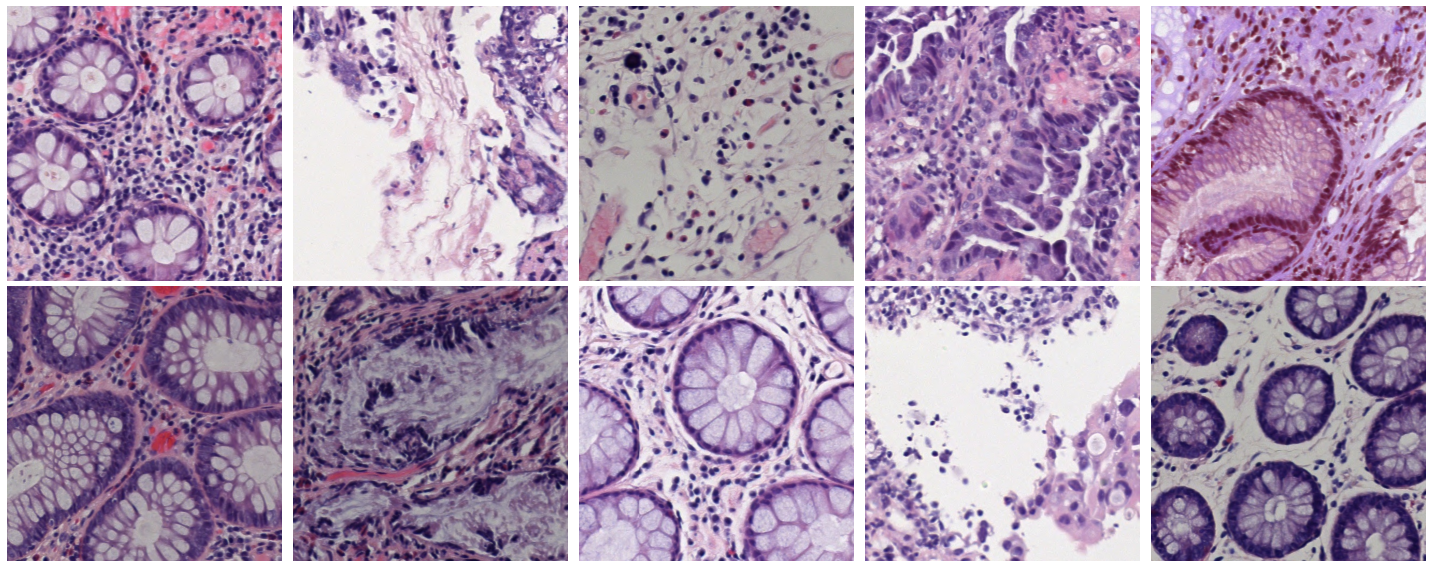

In [76]:
'''
create a function that passes in 3 parameters: image_path, position, and grid_size
when called, the function will create a subplot and place each positions 
'''

def display_image_in_grid(image_path, position, grid_size):
    plt.subplot(*grid_size, position)  # defines each individual subplot within grid. 
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide the axis

# Set the number of images to display
num_images_to_show = 10

# Set Grid size (rows, columns)
grid_size = (2, 5)

plt.figure(figsize=(20, 8))  # Set the figure size (width, height)

# Loop through the first few images and display them in the grid
for i in range(min(num_images_to_show, len(df1))):
    file_path = os.path.join(directory1, df1.iloc[i]['Filename'])
    display_image_in_grid(file_path, i+1, grid_size)

plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()

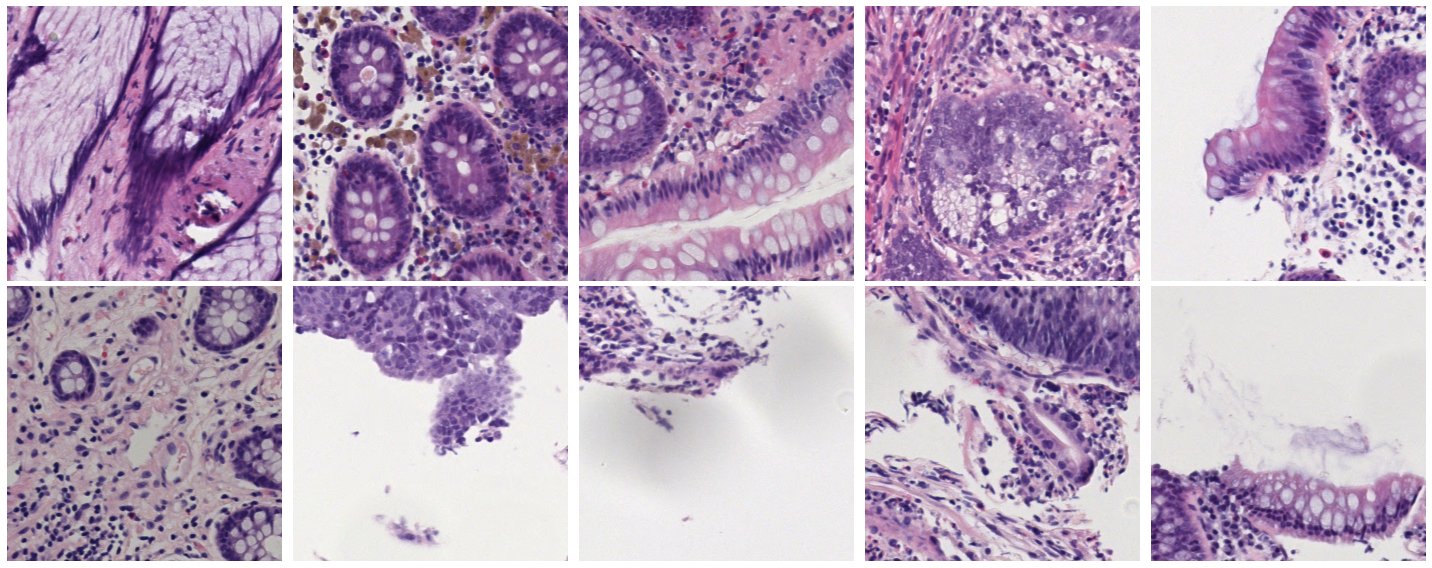

In [77]:
def display_image_in_grid(image_path, position, grid_size):
    plt.subplot(*grid_size, position)  # Create a subplot in the specified grid position
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide the axis

# Number of images to display
num_images_to_show = 10

# Grid size (rows, columns)
grid_size = (2, 5)

plt.figure(figsize=(20, 8))  # Set the figure size (width, height)

# Loop through the first few images and display them in the grid
for i in range(min(num_images_to_show, len(df2))):
    file_path = os.path.join(directory2, df2.iloc[i]['Filename'])
    display_image_in_grid(file_path, i+1, grid_size)

plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()

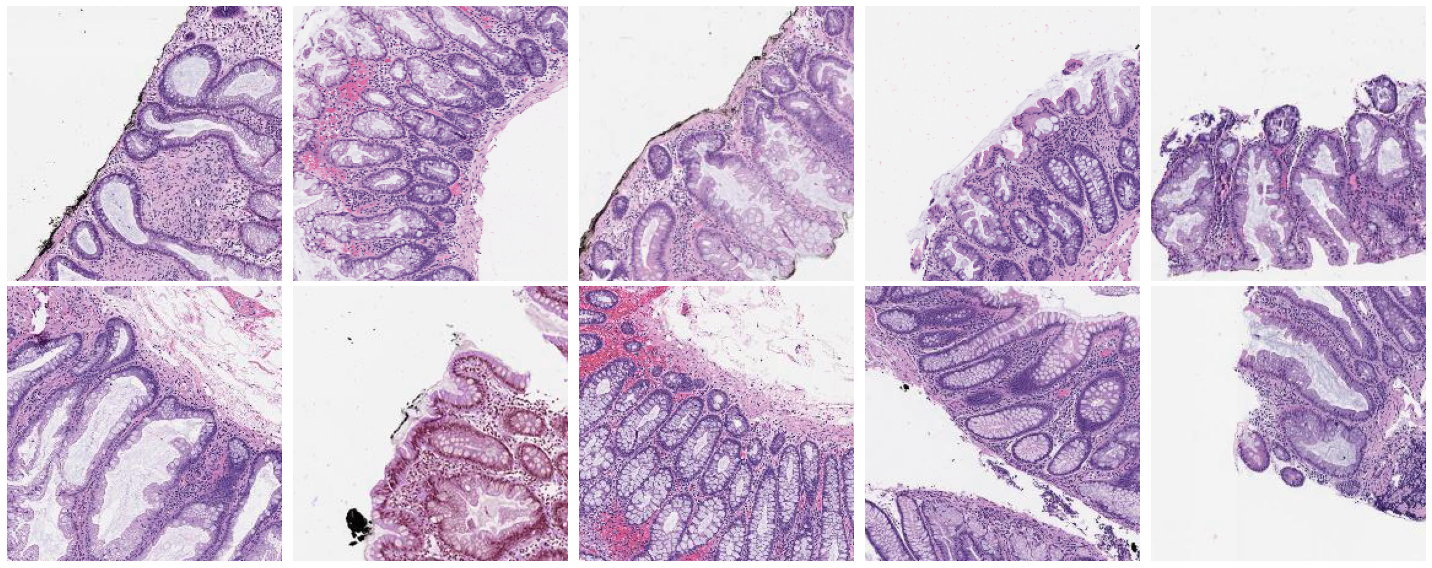

In [78]:
def display_image_in_grid(image_path, position, grid_size):
    plt.subplot(*grid_size, position)  # Create a subplot in the specified grid position
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide the axis

# Number of images to display
num_images_to_show = 10

# Grid size (rows, columns)
grid_size = (2, 5)

plt.figure(figsize=(20, 8))  # Set the figure size (width, height)

# Loop through the first few images and display them in the grid
for i in range(min(num_images_to_show, len(df3))):
    file_path = os.path.join(directory3, df3.iloc[i]['Filename'])
    display_image_in_grid(file_path, i+1, grid_size)

plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()

----------------

# Sprint 2


### Overview
From sprint 1, preliminary EDA was done to look at the 2 datasets from different sources. Although, the sizing between the two are different:
- Chaoyang dataset is 224 x 224
- MHIST dataset is 512 x 512
We can fix this by scaling the images by resizing or cropping the MHIST dataset. 

<br> Another finding are that the labels in:
- Chaoyang dataset has 4 labels "0" means normal, "1" means serrated, "2" means adenocarinoma, and "3" means adenoma 
- MHIST dataset has 2 lables HP (Hyperplastic Polyp) aka normal polyps have no potential to become malignant or SSA (Sessile Serated Adenoma)

So far: 
| DataFrame        | Label | Count |
|------------------|-------|-------|
| mhist_csv_df     | HP    | 617   |
|                  | SSA   | 360   |
| cy_df_train_df   | 2     | 1404  |
|                  | 0     | 1111  |
|                  | 1     | 842   |
|                  | 3     | 664   |
| cy_df_test_df    | 2     | 840   |
|                  | 0     | 705   |
|                  | 1     | 321   |
|                  | 3     | 273   |

Although the MHIST website's Dataset Description shows 3,152 images are in the zip file only 977 were labeled. [MHIST dataset]()

<i>In this case it would be advantagous to have more positive for serated since it can be easily missed.... 
and as false positive to be on the safe side when in the context of health care.... then the idea is that the physician will run more tests. </i>

In the following pre-processing/EDA steps I will:
1. combine images with labels
2. resize the mhist dataset to match chaoyang
3. split the mhist dataset into test and split
4. merge that to the pre-split test and train chaoyang dataset 
5. run the Chaoyang dataset through 
<br> a. Pixel Value Scaling
<br> b. noise detetion
<br> c. data augmentation 
<br> d. edge detection


### combine images with labels with the image datasets

In [79]:
#set file paths and load json files for the chaoyang dataset
# json labels separate file names and labels

cy_train_lables_path = '/Users/yukiekuang/Downloads/train.json'
cy_test_lables_path = '/Users/yukiekuang/Downloads/test.json'

with open(cy_train_lables_path) as f:
    cy_train_labels = json.load(f)

with open(cy_test_lables_path) as f:
    cy_test_labels = json.load(f)


In [80]:
# use pytorch customimagedataset

from torch.utils.data import Dataset
from PIL import Image

In [81]:
#create custom dataset class

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, json_labels, transform=None):
        """
        root_dir: Root directory path where images are stored.
        json_labels: A list of dictionaries, where each dictionary contains 'name' and 'label'.
        transform: Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.json_labels = json_labels
        self.transform = transform
        

    def __len__(self):
        return len(self.json_labels)

    def __getitem__(self, idx):
        # Fetching the 'name' directly as it includes both subdir and filename
        img_path = os.path.join(self.root_dir, self.json_labels[idx]['name'])
        image = Image.open(img_path).convert('RGB')  # Ensuring the image is in RGB format
        label = self.json_labels[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [82]:
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [83]:
cy_train_dataset = CustomImageDataset(root_dir='/Users/yukiekuang/Downloads', json_labels=cy_train_labels)
cy_test_dataset = CustomImageDataset(root_dir='/Users/yukiekuang/Downloads', json_labels=cy_test_labels)

In [84]:
print(f"Train dataset length: {len(cy_train_dataset)}")
print(f"Test dataset length: {len(cy_test_dataset)}")

Train dataset length: 4021
Test dataset length: 2139


In [85]:
#set file paths and load json files for the MHIST dataset
# csv file

cy_train_lables_path = '/Users/yukiekuang/Downloads/train.json'
cy_test_lables_path = '/Users/yukiekuang/Downloads/test.json'

with open(cy_train_lables_path) as f:
    cy_train_labels = json.load(f)

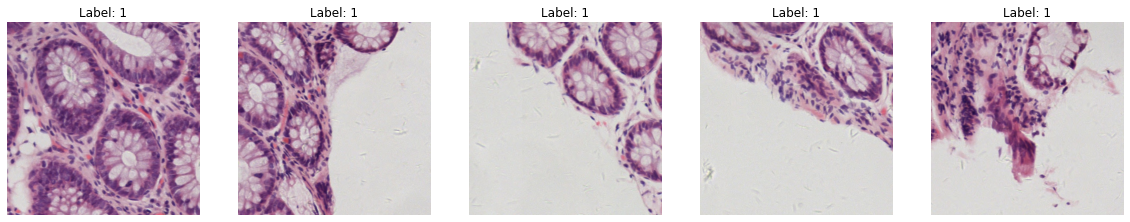

In [86]:
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i, ax in enumerate(axes.flat):
        # Fetch the i-th image from the dataset
        image, label = dataset[i]
        ax.imshow(image)  # If image is a PIL image, no conversion is needed
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.show()

# Show first 5 images and labels from the train dataset
show_images(train_dataset, num_images=5)

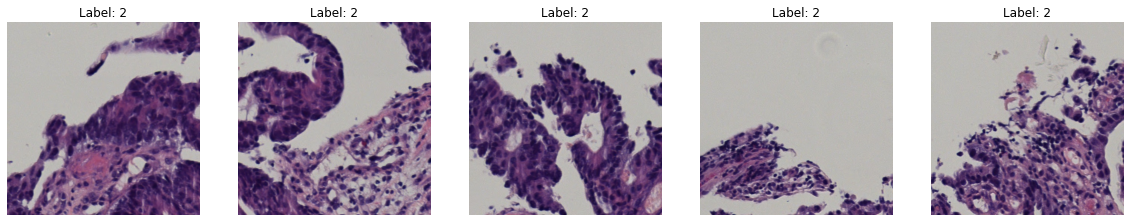

In [88]:
# Show first 5 images and labels from the train dataset
show_images(test_dataset, num_images=5)

In [87]:
#mhist has to be split into train and test 


In total, when combined, this dataset will have: 
- normal - 2478
- serated - 1523
- adenocarcinoma - 2244
- adenoma - 937

Diagnosis of sessile serrated adenoma can be difficult at times, even for experienced pathologists

### Next Steps:

#### Self-Directed Learning 
- how to load json file and convert it into pandas dataframe

#### Resizing and Re-Scaling
The Chaoyang and MHIST images are not the same in px size 
- Chaoyang images are 512 x 512
- MHIST images are 224 x 224

Evaluation - 
Chaoyang images are more zoomed in while the MHIST images are less magnified although the images are smaller. Consider zooming in with the MHIST dataset. 

#### Normalization and standardization 
Some images are darker than others also some hues are brighter than others - explore how this can affect the modeling

#### Data Augmentation
Create some new images by Rotating, scaling, cropping, flipping, and adding color adjustments to help the CNN learn more robustly

#### Baseline Modeling
Create predefined filters to highlight certain features that the CNN can learn from



